In [33]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/GitHub/dynamics-simulation-16-715/lecture-notebooks/Lecture 16/Project.toml`


In [34]:
using LinearAlgebra
using OrdinaryDiffEq
using ForwardDiff
using Plots

In [35]:
#Pendulum Parameters
ℓ = 1.0
m = 1.0
g = 9.81

9.81

In [40]:
#Reference Solution w/ODE Solver

#Classical pendulum dynamics
function f(x,p,t)
    q = x[1]
    v = x[2]
    
    v̇ = -(g/ℓ)*sin(q)
    
    ẋ = [v; v̇]
end

#initial conditions
x0 = [pi/2; 0]

#Simulate
tspan = (0.0,100.0)
prob = ODEProblem(f,x0,tspan)
sol = solve(prob,Tsit5());
#sol = solve(prob,Tsit5(),abstol=1e-5,reltol=1e-5);
#sol = solve(prob,Tsit5(),abstol=1e-6,reltol=1e-6);

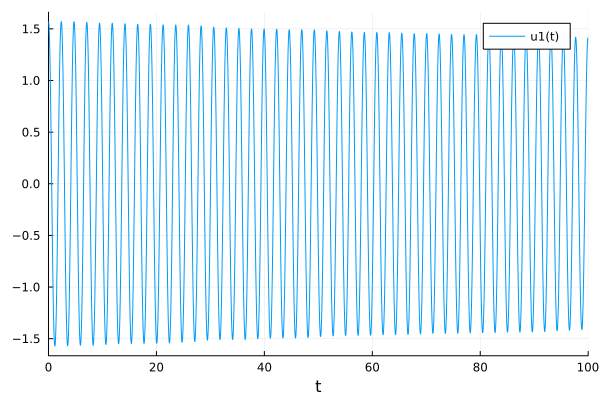

In [41]:
plot(sol,vars=(0,1))

In [42]:
#Energy Functions

function T(θ̇)
    0.5*m*ℓ*ℓ*θ̇*θ̇
end

function U(θ)
    m*g*ℓ*(1-cos(θ))
end

function H(x)
    U(x[1]) + T(x[2])
end

H (generic function with 1 method)

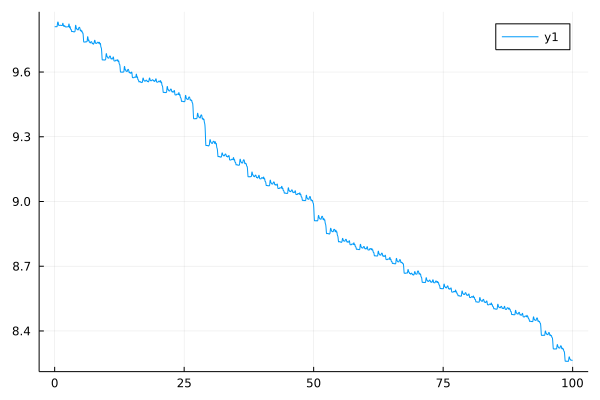

In [43]:
#Plot total energy
h = 0.01 #time step
tk = 0:h:tspan[2]

N = length(tk)
E = zeros(N)
for k = 1:N
    E[k] = H(sol(tk[k]))
end

plot(tk,E)

In [45]:
#Define discrete Lagrangian
function L(q,q̇)
    T(q̇) - U(q)
end

function Ld(q1,q2)
    θm = 0.5*(q1+q2)
    θ̇m = (q2-q1)/h
    return h*L(θm,θ̇m)
end

Ld (generic function with 1 method)

In [46]:
#Let's do this again with the discrete Legendre transform

function D1Ld(q1,q2)
    ForwardDiff.derivative(dq1->Ld(dq1,q2),q1)
end

function D2Ld(q1,q2)
    ForwardDiff.derivative(dq2->Ld(q1,dq2),q2)
end

#Initial conditions
q1 = x0[1]
v1 = x0[2]
p1 = m*v1

qhist = zeros(length(tk))
qhist[1] = q1
phist = zeros(length(tk))
phist[1] = p1

for k = 1:(length(tk)-1)
    qhist[k+1] = qhist[k]
    
    #Calculate residual with right discrete Legendre transform
    r = phist[k] + D1Ld(qhist[k],qhist[k+1])
    
    #Newton's method to solve for q_k+1
    while norm(r) > 1e-12
        R = ForwardDiff.derivative(dqn->D1Ld(qhist[k],dqn),qhist[k+1])
        qhist[k+1] = qhist[k+1] - R\r
        r = phist[k] + D1Ld(qhist[k],qhist[k+1])
    end
    
    #Update momentum (left discrete Legendre transform)
    phist[k+1] = D2Ld(qhist[k],qhist[k+1])
end

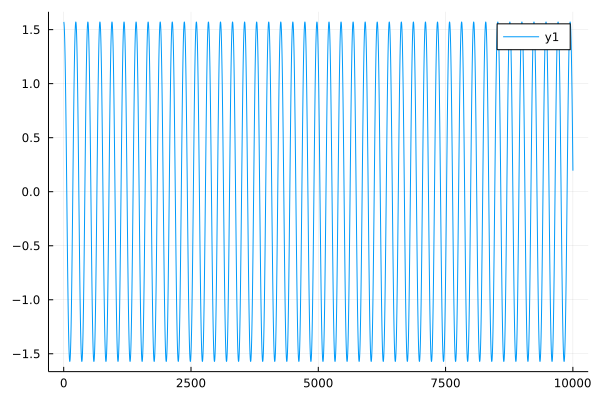

In [47]:
plot(qhist)

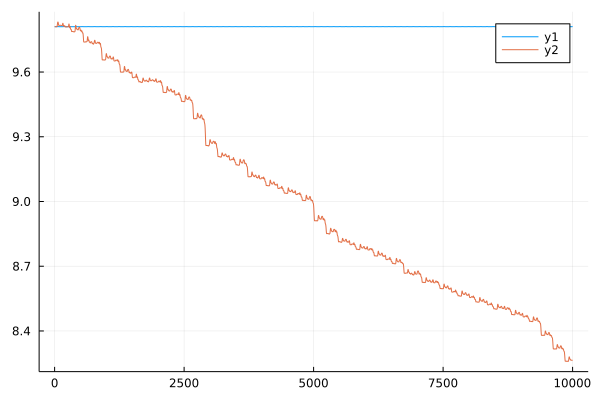

In [48]:
#Plot energy

E2 = zeros(length(tk))
for k = 1:(length(tk))
    E2[k] = (0.5/m)*phist[k]*phist[k] + U(qhist[k])
end

plot(E2)
plot!(E)

In [49]:
#Implicit Midpoint

xhist = zeros(2,length(tk))
xhist[:,1] .= x0

for k = 1:(length(tk)-1)
    xhist[:,k+1] .= xhist[:,k]
    r = xhist[:,k+1] - xhist[:,k] - h*f(0.5*(xhist[:,k+1]+xhist[:,k]),[],[])
    
    #Newton's method
    while norm(r) > 1e-12
        R = I - 0.5*h*ForwardDiff.jacobian(dx->f(dx,[],[]),0.5*(xhist[:,k+1]+xhist[:,k]))
        xhist[:,k+1] .= xhist[:,k+1] - R\r
        r = xhist[:,k+1] - xhist[:,k] - h*f(0.5*(xhist[:,k+1]+xhist[:,k]),[],[])
    end
end

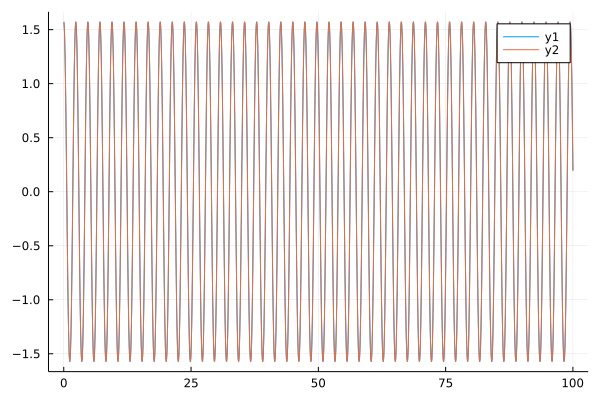

In [50]:
plot(tk,xhist[1,:])
plot!(tk,qhist)

In [51]:
#Plot total energy

E3 = zeros(length(tk))
for k = 1:(length(tk))
    E3[k] = H(xhist[:,k])
end

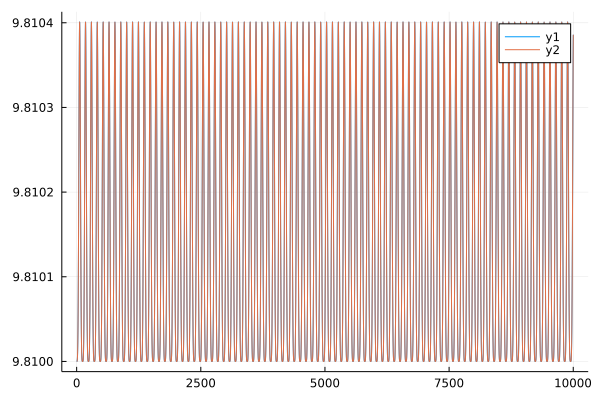

In [52]:
plot(E2)
plot!(E3)

In [53]:
qhist-xhist[1,:]

10001-element Vector{Float64}:
  0.0
  0.0
  0.0
  2.220446049250313e-16
  4.440892098500626e-16
  6.661338147750939e-16
  8.881784197001252e-16
  1.1102230246251565e-15
  1.3322676295501878e-15
  1.7763568394002505e-15
  1.9984014443252818e-15
  2.220446049250313e-15
  2.6645352591003757e-15
  ⋮
 -5.295763827461997e-12
 -5.37314637227837e-12
 -5.4461990472987054e-12
 -5.51481083022054e-12
 -5.578759676438949e-12
 -5.637879052500239e-12
 -5.692002424950715e-12
 -5.741018771487916e-12
 -5.784761558658147e-12
 -5.823119764158946e-12
 -5.855982365687851e-12
 -5.883266096518014e-12

In [54]:
phist-xhist[2,:]

10001-element Vector{Float64}:
  0.0
 -4.871103520542874e-15
  5.9396931817445875e-15
  1.404432126150823e-14
  2.120525977034049e-14
  3.1308289294429414e-14
  2.986499936241671e-14
  2.6423307986078726e-14
  3.164135620181696e-14
  3.4638958368304884e-14
  2.7977620220553945e-14
  2.7533531010703882e-14
  3.530509218307998e-14
  ⋮
 -7.955414105254022e-12
 -7.528644374588112e-12
 -7.0894401460464e-12
 -6.635580973579636e-12
 -6.1595173406203685e-12
 -5.668354674526199e-12
 -5.160316618457728e-12
 -4.640732242933154e-12
 -4.108713369532779e-12
 -3.5642599982566026e-12
 -3.0100366643637244e-12
 -2.446931546273845e-12